### Maximum Likelihood tree inference

Sequences generated in for this study are in the following files:

 - `sequences/Gammarus_sp_SANGER.nr.fasta` #Sanger sequences
 - `../3-extract_haplotypes/Gammarus_sp_from_metaBEAT.fasta` #haplotyes extracted from metabarcoding data
 
Other Gammarid COI sequences from Weiss et al. 2014 are at:
 - `../1-download_reference/Gammarus_COI_refseqs.gb`

Find the Reprophylo manual [here](https://docs.google.com/document/d/1Q-8B0cvkZw2zMkuP0Af4zZ7FiAvBQPDdGbrLLMgtx_4/edit#).

Import reprophylo functions.

In [1]:
from reprophylo import *

Specifying the locus/loci to be used in the analyses.

The Genbank input files may contain sequences for a range of genes (say you have downloaded full mitochondrial genomes), but you are only interested in a particular gene (say COI). 

So, first we'll want to get an overview of all the genes present in your input Genbank file. Reprophylo has a function for that.

The function will write tentative locus descriptions to the file `loci.csv`, which you may modify, e.g. exclude certain genes from the loci file, or synonymize gene names if necessary.

In [2]:
list_loci_in_genbank('../1-download_references/Gammarus_COI_refseqs.gb', 'loci.csv')


There are 2 gene names (or gene product names) detected
----------------------------------
Gene and count sorted by gene name
----------------------------------
27 instances of CDS,COI
72 instances of CDS,cytochrome oxidase subunit 1
-------------------------------
Gene and count sorted by counts
-------------------------------
72 instances of CDS,cytochrome oxidase subunit 1
27 instances of CDS,COI


The function summarizes all gene names detected in the Genbank file. Reprophylo internally already contains a list of synoyms for common genes and attempts to summarize all unique gene names in the file `loci.csv`. 

In [3]:
!cat loci.csv

dna,CDS,MT-CO1,COI
dna,CDS,cytochrome_oxidase_subunit_1,cytochrome oxidase subunit 1


Based on the file `loci.csv` produced by the function we prepare a file `target_loci.csv` that contains all synonyms for the COI gene that appear in the Genbank file. 

In [4]:
%%file target_loci.csv
dna,CDS,MT-CO1,COI,1
dna,CDS,cytochrome_oxidase_subunit_1,cytochrome oxidase subunit 1,1

Overwriting target_loci.csv


Start a new Reprophylo project, specifying/characterizing the loci to be processed via the `loci.csv` file that we have prepared.

In [5]:
pj = Project('target_loci.csv', pickle='my_project.pickle', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


Check if the Reprophylo project was created correctly.

In [6]:
print pj

Project object with the loci MT-CO1,


Reading in the sequences from Genbank format.

In [7]:
input_files=['../1-download_references/Gammarus_COI_refseqs.gb']
pj.read_embl_genbank(input_files)

/home/reprophylo/reprophylo.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


All sequences are now stored in memory as 'sequence records'. 

How many sequences does our dataset contain?

In [8]:
print len(pj.records)

99


Reading in the new sequences produced from Sanger sequencing or metabarcoding. They will be added to the sequence records with the id 'denovo'

In [9]:
denovo_sequence_filenames=['sequences/Gammarus_sp_SANGER.nr.fasta', 
 '../3-extract_haplotypes/Gammarus_sp_from_metaBEAT.fasta']

pj.read_denovo(denovo_sequence_filenames, 'dna', format='fasta')

19

In [10]:
print len(pj.records)

118


We are assuming that the sequences that came from Genbank are already in the correct orientation, but we should check that our custom sequences need to be inverted. 

We'll use the `blast` program and a few functions to do that.

`blastn` is installed in the image. Otherwise on ubuntu install like so:

In [11]:
!apt-get install ncbi-blast+

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ncbi-blast+ is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 287 not upgraded.


In [12]:
!mkdir temp

Write all sequences to file `temp.fasta`.

In [13]:
from Bio import SeqIO

output_handle = open("temp/test.fasta", "w")
SeqIO.write(pj.records, output_handle, "fasta")
output_handle.close()

Convert `temp.fasta` to blast database.

In [14]:
!makeblastdb -in temp/test.fasta -dbtype nucl -out temp/all



Building a new DB, current time: 01/13/2017 09:32:29
New DB name:   temp/all
New DB title:  temp/test.fasta
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 118 sequences in 0.00350595 seconds.


Perform blast search.

In [15]:
!blastn -db temp/all -query temp/test.fasta -outfmt '6 qseqid sseqid qstart qend sstart send' -out temp/test.blastn.out

Identify any denovo sequences that match with non-denovo sequences in reverse complement.

In [16]:
blastout=open('temp/test.blastn.out')

to_invert=[]
for line in blastout:
    col=line.strip().split("\t")
    if 'denovo' in col[0]:
#        print col
        if (int(col[-2]) > int(col[-1])) and (not 'denovo' in col[1]):
#            print "## invert ##"
            to_invert.append(col[0])
        
to_invert=list(set(to_invert))
print "Records to invert:\n%s" %to_invert

blastout.close()

Records to invert:
['denovo0', 'denovo1', 'denovo2', 'denovo3', 'denovo4']


Reverse complement records.

In [17]:
if to_invert:
    print "There are records to invert\n"
    for r in pj.records:
        if r.id in to_invert:
            print "\t-> %s" %r.id
            r.seq = r.seq.reverse_complement()
            to_invert.remove(r.id)
else:
    print "Nothing to invert\n"

There are records to invert

	-> denovo0
	-> denovo1
	-> denovo2
	-> denovo3
	-> denovo4


Remove temporal directory.

In [18]:
!rm -rf temp

Now, lets print a summary of the number of sequences per species.

In [19]:
pj.species_vs_loci('species.csv')

In [20]:
!cat species.csv

Some sequences seem to be missing. This is because the `species_by_loci` function only considers sequence records that are identified with the correct gene identifier. We need to add this for our custom sequences so that reprophylo understands that these sequences are to be analysed together with the COI sequences that we have loaded from the Genbank data.

In [21]:
for r in pj.records:
    if 'denovo' in r.id:
        pj.add_feature_to_record(r.id, 'CDS', qualifiers={'gene': 'MT-CO1'})

In [22]:
pj.species_vs_loci('species.csv')

In [23]:
!cat species.csv

Better, but our custom sequences are now assigned to an undefied species. We'll need to add the species to the record. We will look in the original header of the sequence for the species name and add the appropriate organism name to the sequence record.

In [24]:
for r in pj.records:
    source=r.features[0]
    if 'denovo' in r.id:
        if 'pulex' in source.qualifiers['original_id'][0]:
            r.features[0].qualifiers['organism'] = ['Gammarus pulex']
        elif 'fossarum' in source.qualifiers['original_id'][0]:
            r.features[0].qualifiers['organism'] = ['Gammarus fossarum']


In [25]:
pj.species_vs_loci('species.csv')

In [26]:
!cat species.csv

_Gammarus fossarum_ is considered a complex of cryptic species. To make our lives easier for the analyses we'll correct the tentative species names _Gammarus cf. fossarum_ as used by Copilas-Ciocianu and Petrusek 2015 to simply _G. fossarum_.

In [27]:
for r in pj.records:
    source=r.features[0]
    if 'Gammarus cf. fossarum' in source.qualifiers['organism'][0]:
        #keep the original tentative identification in separate qualifier
        source.qualifiers['tentative'] = [source.qualifiers['organism'][0]]
        #rename organism to simply Gammarus fossarum
        source.qualifiers['organism'] = ['Gammarus fossarum']

In [28]:
pj.species_vs_loci('species.csv')

In [29]:
!cat species.csv

There! Now, let's produce some stats for the sequences in our dataset.

In [31]:
pj.extract_by_locus()

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


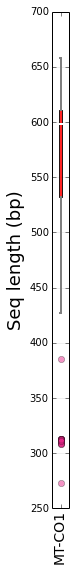

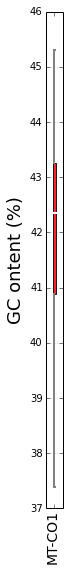

In [32]:
%matplotlib inline
pj.report_seq_stats()


The sequences in the dataset are of different lengths. Sequences downloaded from Genbank (generated by Hou et al. 2007; Hou et al. 2011; Weiss et al. 2014; Copilas-Ciocianu & Petrusek 2015) are mostly full length COI barcoding fragments (Folmer et al. 1994). Sanger sequences produced by the current were also based on the full length COI barcode. Sequences obtained via eDNA metabarcoding approach are shorter (~313bp).

We will generate three separate alignments.
 - 'ALL': All sequences from Genbank and current study (Sanger Folmer- and metabarcoding mini-barcode fragment)
 - 'FOLMER': Sequences from Genbank and current study Sanger Folmer fragments only
 - 'MINIBC': Sequences from Genbank and current study metabarcoding mini-barcode fragments only

Configure and run sequence alignment 'ALL' with mafft.

In [33]:
mafft_linsi = AlnConf(pj, 
                      method_name='ALL', 
                      CDSAlign=False, 
                      program_name='mafft', 
                      cmd='mafft', 
                      loci=['MT-CO1'], 
                      cline_args={'localpair': True, 'maxiterate': 1000})

mafft --localpair --maxiterate 1000 287521484299993.59_MT-CO1.fasta


Execute sequence alignment process.

In [34]:
pj.align([mafft_linsi])

Display information about the alignment method.

In [35]:
print pj.used_methods['ALL']

AlnConf named ALL with ID 287521484299993.59
Loci: MT-CO1 
Created on: Fri Jan 13 09:33:13 2017
Commands:
MT-CO1: mafft --localpair --maxiterate 1000 287521484299993.59_MT-CO1.fasta

Environment:
Platform: Linux-4.4.0-53-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: chrishah-OptiPlex-7040
 Program and version: MAFFT v7.123b
 Program reference:Katoh
 Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alignment software version 7: improvements in performance and usability.
execution time:
17.9483218193


Core Methods section sentence:
The dataset(s) MT-CO1 were aligned using the program MAFFT v7.123b [1].

Reference:
Katoh, Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multip

Produce the alignemnt 'FOLMER', i.e. remove all minibarcode sequences. These have the ids >= 'denovo5'.

In [48]:
for r in pj.records:
    if 'denovo' in r.id:
        print r.id,r.description

denovo0 R_Taff_G.pulex_HCO2198
denovo1 Little_Stour_G_fossarum_2_HCO2198
denovo2 R_Taff_G_fossarum_1_HCO2198
denovo3 R_Taff_G_fossarum_2_HCO2198
denovo4 Little_Stour_G_fossarum_1_HCO2198
denovo5 Gammarus_pulex|Gp_UK_Mb01
denovo6 Gammarus_pulex|Gp_UK_Mb02
denovo7 Gammarus_pulex|Gp_UK_Mb03
denovo8 Gammarus_pulex|Gp_UK_Mb04
denovo9 Gammarus_pulex|Gp_UK_Mb05
denovo10 Gammarus_pulex|Gp_UK_Mb06
denovo11 Gammarus_pulex|Gp_UK_Mb07
denovo12 Gammarus_pulex|Gp_UK_Mb08
denovo13 Gammarus_pulex|Gp_UK_Mb09
denovo14 Gammarus_fossarum|Gf_UK_Mb01
denovo15 Gammarus_fossarum|Gf_UK_Mb02
denovo16 Gammarus_fossarum|Gf_UK_Mb03
denovo17 Gammarus_fossarum|Gf_UK_Mb04
denovo18 Gammarus_fossarum|Gf_UK_Mb05


In [49]:
#Empty sequence object
seqobject = []

#Add all records except the record ids >= 'denovo6' to new object
for r in pj.records_by_locus['MT-CO1']:
    if 'denovo' in r.id:
        denovoID=int(r.id.replace('denovo','').replace('_f0',''))
#        print denovoID
        if denovoID >= 5:
            pass
        else:
            seqobject.append(r)
    else:
        seqobject.append(r)

#Replace original object with new 
pj.records_by_locus['MT-CO1'] = seqobject

Configure and run alignment.

In [50]:
mafft_linsi = AlnConf(pj, 
                      method_name='FOLMER', 
                      CDSAlign=False, 
                      program_name='mafft', 
                      cmd='mafft', 
                      loci=['MT-CO1'], 
                      cline_args={'localpair': True, 'maxiterate': 1000})

mafft --localpair --maxiterate 1000 647731484300507.53_MT-CO1.fasta


In [51]:
pj.align([mafft_linsi])

Restore original alignemnt object.

In [60]:
pj.extract_by_locus()

Produce the alignemnt 'MINIBC', i.e. remove all minibarcode sequences. These have ids <= 'denovo4'.

In [61]:
#Empty sequence object
seqobject = []

#Add all records except the record ids >= 'denovo6' to new object
for r in pj.records_by_locus['MT-CO1']:
    if 'denovo' in r.id:
        denovoID=int(r.id.replace('denovo','').replace('_f0',''))
#        print denovoID
        if denovoID <= 4:
            pass
        else:
            seqobject.append(r)
    else:
        seqobject.append(r)

#Replace original object with new 
pj.records_by_locus['MT-CO1'] = seqobject

Configure and run alignment.

In [62]:
mafft_linsi = AlnConf(pj, 
                      method_name='MINIBC', 
                      CDSAlign=False, 
                      program_name='mafft', 
                      cmd='mafft', 
                      loci=['MT-CO1'], 
                      cline_args={'localpair': True, 'maxiterate': 1000})

mafft --localpair --maxiterate 1000 276191484300646.68_MT-CO1.fasta


In [63]:
pj.align([mafft_linsi])

Restore original alignment object.

In [64]:
pj.extract_by_locus()

Write alignments to files for checking in e.g. `Aliview`.

In [65]:
pj.write_alns(id=['record_id', 'source_organism'], format='fasta')

['MT-CO1@MINIBC_aln.fasta', 'MT-CO1@FOLMER_aln.fasta', 'MT-CO1@ALL_aln.fasta']

Trim each of the three alignemnts to remove any positions that are not covered by at least 70, 80, and 90% of the records.

In [66]:
gt70trimal = TrimalConf(pj, 
                        method_name='gt70', 
                        program_name='trimal', 
                        cmd='trimal', 
                        alns=['MT-CO1@ALL', 'MT-CO1@FOLMER', 'MT-CO1@MINIBC'], 
                        trimal_commands={'gt': 0.7})

trimal -in 178771484300685.65_MT-CO1@MINIBC.fasta -gt 0.7
trimal -in 178771484300685.65_MT-CO1@FOLMER.fasta -gt 0.7
trimal -in 178771484300685.65_MT-CO1@ALL.fasta -gt 0.7


In [67]:
gt80trimal = TrimalConf(pj, 
                        method_name='gt80', 
                        program_name='trimal', 
                        cmd='trimal', 
                        alns=['MT-CO1@ALL', 'MT-CO1@FOLMER', 'MT-CO1@MINIBC'], 
                        trimal_commands={'gt': 0.8})

trimal -in 658571484300688.13_MT-CO1@MINIBC.fasta -gt 0.8
trimal -in 658571484300688.13_MT-CO1@FOLMER.fasta -gt 0.8
trimal -in 658571484300688.13_MT-CO1@ALL.fasta -gt 0.8


In [68]:
gt90trimal = TrimalConf(pj, 
                        method_name='gt90', 
                        program_name='trimal', 
                        cmd='trimal', 
                        alns=['MT-CO1@ALL', 'MT-CO1@FOLMER', 'MT-CO1@MINIBC'], 
                        trimal_commands={'gt': 0.9})

trimal -in 332591484300688.78_MT-CO1@MINIBC.fasta -gt 0.9
trimal -in 332591484300688.78_MT-CO1@FOLMER.fasta -gt 0.9
trimal -in 332591484300688.78_MT-CO1@ALL.fasta -gt 0.9


In [69]:
pj.trim([gt70trimal,gt80trimal,gt90trimal])

In [70]:
print pj.used_methods['gt90']

TrimalConf named gt90 with ID 332591484300688.78
Alignments: MT-CO1@MINIBC,MT-CO1@FOLMER,MT-CO1@ALL 
Created on: Fri Jan 13 09:44:48 2017
Commands:
MT-CO1@FOLMER@gt90: trimal -in 332591484300688.78_MT-CO1@FOLMER.fasta -gt 0.9
MT-CO1@ALL@gt90: trimal -in 332591484300688.78_MT-CO1@ALL.fasta -gt 0.9
MT-CO1@MINIBC@gt90: trimal -in 332591484300688.78_MT-CO1@MINIBC.fasta -gt 0.9

Environment:Platform: Linux-4.4.0-53-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: chrishah-OptiPlex-7040
 Program and version: trimAl 1.2rev59
 Program reference: Salvador Capella-Gutierrez; Jose M. Silla-Martinez; Toni Gabaldon. trimAl: a tool for automated alignment trimming in large-scale phylogenetic analyses. Bioinformatics 2009 25: 1972-1973.
exec

In [71]:
pj.write_trimmed_alns(id=['record_id', 'source_organism'], format='fasta')

['MT-CO1@MINIBC@gt80_trimmed_aln.fasta',
 'MT-CO1@ALL@gt70_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt90_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt80_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt80_trimmed_aln.fasta']

Configure tree building.

In [72]:
raxml = RaxmlConf(pj, method_name='mafftLinsi-trimal', 
                 program_name='raxmlHPC-PTHREADS-SSE3',
                 keepfiles=True,
                 cmd='raxmlHPC-PTHREADS-SSE3',
                 preset='fa',
                 alns=['MT-CO1@FOLMER@gt80','MT-CO1@ALL@gt80','MT-CO1@MINIBC@gt80',
                      'MT-CO1@FOLMER@gt70','MT-CO1@ALL@gt70','MT-CO1@MINIBC@gt70',
                      'MT-CO1@FOLMER@gt90','MT-CO1@ALL@gt90','MT-CO1@MINIBC@gt90'],
                 model='GAMMA',
                 threads=3,
                 cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@MINIBC@gt800 -p 566 -s 345621484300695.25_MT-CO1@MINIBC@gt80.fasta -T 3 -x 554 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@ALL@gt700 -p 738 -s 345621484300695.25_MT-CO1@ALL@gt70.fasta -T 3 -x 744 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@MINIBC@gt900 -p 168 -s 345621484300695.25_MT-CO1@MINIBC@gt90.fasta -T 3 -x 941 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@MINIBC@gt700 -p 348 -s 345621484300695.25_MT-CO1@MINIBC@gt70.fasta -T 3 -x 826 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@ALL@gt800 -p 894 -s 345621484300695.25_MT-CO1@ALL@gt80.fasta -T 3 -x 144 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@FOLMER@gt700 -p 469 -s 345621484300695.25_MT-CO1@FOLMER@gt70.fasta -T 3 -x 352 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@ALL@gt900 -p 

In [73]:
pj.tree([raxml])

In [74]:
print pj.used_methods['mafftLinsi-trimal']

RaxmlConf named mafftLinsi-trimal with ID 345621484300695.25
Alignments: MT-CO1@MINIBC@gt80,MT-CO1@ALL@gt70,MT-CO1@MINIBC@gt90,MT-CO1@MINIBC@gt70,MT-CO1@ALL@gt80,MT-CO1@FOLMER@gt70,MT-CO1@ALL@gt90,MT-CO1@FOLMER@gt90,MT-CO1@FOLMER@gt80 
Created on: Fri Jan 13 09:44:55 2017
Commands:
MT-CO1@MINIBC@gt80:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@MINIBC@gt800 -p 566 -s 345621484300695.25_MT-CO1@MINIBC@gt80.fasta -T 3 -x 554 -N 100
MT-CO1@ALL@gt70:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@ALL@gt700 -p 738 -s 345621484300695.25_MT-CO1@ALL@gt70.fasta -T 3 -x 744 -N 100
MT-CO1@MINIBC@gt90:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@MINIBC@gt900 -p 168 -s 345621484300695.25_MT-CO1@MINIBC@gt90.fasta -T 3 -x 941 -N 100
MT-CO1@MINIBC@gt70:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 345621484300695.25_MT-CO1@MINIBC@gt700 -p 348 -s 345621484300695.25_MT-CO1@MINIBC@gt70.fasta -T 3 -x 826 -N 100
MT-CO1@ALL@gt80:
raxmlHPC-

Pickle the project.

In [75]:
pickle_pj(pj, 'my_project.pickle')

'my_project.pickle'

Annotate ML trees.

Define outgroups.

In [76]:
!cat species.csv

In [77]:
pj.add_qualifier_from_source('organism')


In [78]:
for species in ['balcanicus', 'glabratus', 'roeselii', 'tigrinus']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

Specify colors for branchsupport.

In [79]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}


Add a new qualifier 'origin' that contains either 'Sanger' or 'metabarcoding' for the newly generated sequences. Also we add another qualifier 'origin_abr' that contains the symbols * or +, respectively.



In [ ]:
for r in pj.records:
    if 'denovo' in r.id:
        print r.id
        ## all the Sanger sequences contain the string 'HCO2198' in the sequence header
        if 'HCO2198' in r.description:
            print "origin -> Sanger"
            for f in r.features:
                f.qualifiers['origin'] = ['Sanger']
                f.qualifiers['origin_abr'] = ['*']
        ## if they are don't contain 'HCO2198' they originate from metabarcoding
        else:
            print "origin -> metabarcoding"
            for f in r.features:
                f.qualifiers['origin'] = ['metabarcoding']
                f.qualifiers['origin_abr'] = ['+']
    #if they are not 'denovo' then they were from a previous study
    else:
        print r.id
        print "origin -> previous study"
        for f in r.features:
            f.qualifiers['origin'] = ['']
            f.qualifiers['origin_abr'] = ['']

In [81]:
pj.propagate_metadata()

Refine tree annotation.

Format tree to add symbols * or + to leaf name to indicate 'Sanger' or 'metabarcoding' sequences, respectively.

In [82]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outroup', 
            ['source_organism', 'record_id','origin_abr'], 
            node_support_dict=supports, multifurc=50,
            html='./mafftLinsi-trimal-raxml.html')

Color the tree labels according to origin of the sequences.

In [83]:
leaf_colors = {'Sanger':'red', 'metabarcoding': 'blue'}

In [84]:
pj.clear_tree_annotations()
pj.annotate('.', 'mid', 'mid', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=50, #None
            leaf_node_color_meta = 'origin', leaf_label_colors = leaf_colors,
            html='./mafftLinsi-trimal-raxml.html')

Add haplotype abbreviations to records to be used as tree tip labels.

In [ ]:
MB_count={'Gp':1, 'Gf':1}
FO_count={'Gp':1, 'Gf':1}
for r in pj.records:
    print r.id,r.features[0].qualifiers['organism'][0]

    if r.features[0].qualifiers['organism'][0].split(" ")[1] in ['pulex','fossarum']:
        sp_prefix = r.features[0].qualifiers['organism'][0].split(" ")[0][0]+r.features[0].qualifiers['organism'][0].split(" ")[1][0]
        if 'denovo' in r.id:
            if 'metabarcoding' in r.features[0].qualifiers['origin']:
                for f in r.features:
                    f.qualifiers['label'] = [r.description.split("|")[1]]
                print r.features[0].qualifiers['label']
                MB_count[sp_prefix]+=1
            if 'Sanger' in r.features[0].qualifiers['origin']:
                for f in r.features:
                    f.qualifiers['label'] = [sp_prefix+'_UK_Fo'+"%02d" %FO_count[sp_prefix]]
                print r.features[0].qualifiers['label']
                FO_count[sp_prefix]+=1
        elif r.id.startswith('KR'): #These are the records from Copilas-Ciocianu & Petrusek 2015
            for f in r.features:
                f.qualifiers['label'] = [sp_prefix+'_'+r.features[0].qualifiers['country'][0][:3]+'_'+r.features[0].qualifiers['isolate'][0]]
            print r.features[0].qualifiers['label']
        elif r.id.startswith('KF'): #These are the records from Weiss et al. 2014
            for f in r.features:
                f.qualifiers['label'] = r.features[0].qualifiers['specimen_voucher']
            print r.features[0].qualifiers['label']
        else: #These are the remaining records from Hou et al. 2007 and Hou et al. 2011
            for f in r.features:
                f.qualifiers['label'] = [sp_prefix+'_'+r.features[0].qualifiers['country'][0][:3]+'_'+r.features[0].qualifiers['specimen_voucher'][0]]
            print r.features[0].qualifiers['label']
    else:
        for f in r.features:
            f.qualifiers['label'] = r.features[0].qualifiers['organism']
        print r.features[0].qualifiers['label']

In [87]:
pj.propagate_metadata()

In [90]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['label'], 
            node_support_dict=supports, multifurc=None,
            leaf_node_color_meta = 'origin', leaf_label_colors = leaf_colors,
            html='./mafftLinsi-trimal-raxml.html')

Write out alignments again, adding the new label names.

In [91]:
pj.write_alns(id=['record_id', 'label'], format='fasta')

['MT-CO1@MINIBC_aln.fasta', 'MT-CO1@FOLMER_aln.fasta', 'MT-CO1@ALL_aln.fasta']

In [92]:
pj.write_trimmed_alns(id=['record_id', 'label'], format='fasta')

['MT-CO1@MINIBC@gt80_trimmed_aln.fasta',
 'MT-CO1@ALL@gt70_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt90_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt80_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt80_trimmed_aln.fasta']

Copy phylogenetic trees and underlying alignments in separate directory as supplement for the paper.

In [96]:
mkdir supplementary

In [97]:
%%bash

#copy and rename phylogenies
for p in $(ls -1 *.png)
do
    base=$(echo $p | cut -d "_" -f 2-)
    cp $p supplementary/RAxML_GTRGAMMA-$base
done

#copy alignments
cp MT-CO1* supplementary/

In [152]:
!mkdir supplementary/RAxML/

In [153]:
!mv RAxML_* supplementary/RAxML/

Pickle Reprophylo project for later.

In [100]:
pickle_pj(pj, 'my_project.pickle')

'my_project.pickle'

In [154]:
!cp my_project.pickle supplementary/

Generate supplementary table linking haplotypes with accession numbers.

In [4]:
references = {}

#previously published sequences used in the phylogeny
refs = open('../1-download_references/phylogeny_refseqs.csv','r')
refs.next()
for r in refs:
    cols=r.strip().split(",")
    references[cols[1]] = cols[2]

hts = {}   

#read in Genbank accessions for sequences produced in this study from text file
acc_fh = open('supplementary/this_study_ht_to_accessions.tsv')
ht_to_new_accs = {}
for ht in acc_fh:
    ht_to_new_accs[ht.strip().split("\t")[0]] = ht.strip().split("\t")[1]

#
for r in pj.records:
    hts[r.features[0].qualifiers['label'][0]] = "%s" %r.features[0].qualifiers['organism'][0]
    
    if ".".join(r.id.split(".")[:-1]) in references:
        hts[r.features[0].qualifiers['label'][0]]+= "\t%s\t%s" %(r.id, references[".".join(r.id.split(".")[:-1])])

    else:
        hts[r.features[0].qualifiers['label'][0]]+= "\t"+ht_to_new_accs[r.features[0].qualifiers['label'][0]]+"\tcurrent study"


out='sequence id\tspecies\tGenbank accession\treference\n'
for s in sorted(hts.keys()):
    out+="%s\t%s\n" %(s, hts[s])

print out

outfh=open('supplementary/ht_accessions.tsv','w')
outfh.write(out)
outfh.close()

sequence id	species	Genbank accession	reference
Gammarus balcanicus	Gammarus balcanicus	JF965914.1	Hou et al. (2011)
Gammarus glabratus	Gammarus glabratus	EF570307.1	Hou et al. 2009
Gammarus roeselii	Gammarus roeselii	JF965952.1	Hou et al. (2011)
Gammarus tigrinus	Gammarus tigrinus	FJ581688.1	Radulovici et al. (2009)
Gf_BF_N1	Gammarus fossarum	KF521829.1	Weiss et al. (2013)
Gf_BF_N2	Gammarus fossarum	KF521828.1	Weiss et al. (2013)
Gf_BF_N3	Gammarus fossarum	KF521827.1	Weiss et al. (2013)
Gf_BF_S1	Gammarus fossarum	KF521832.1	Weiss et al. (2013)
Gf_BF_S2	Gammarus fossarum	KF521831.1	Weiss et al. (2013)
Gf_BF_S3	Gammarus fossarum	KF521830.1	Weiss et al. (2013)
Gf_Cro5_01	Gammarus fossarum	KF521806.1	Weiss et al. (2013)
Gf_Cro5_02	Gammarus fossarum	KF521805.1	Weiss et al. (2013)
Gf_Cro8_01	Gammarus fossarum	KF521804.1	Weiss et al. (2013)
Gf_Cro8_02	Gammarus fossarum	KF521803.1	Weiss et al. (2013)
Gf_Cro8_03	Gammarus fossarum	KF521802.1	Weiss et al. (2013)
Gf_Ger6_01	Gammarus fossarum	KF52